In [ ]:
%tensorflow_version 1.x
import numpy as np
#import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LSTM, Reshape, Input, Concatenate, ZeroPadding2D, GlobalMaxPool2D
from keras.models import Model
import matplotlib.pyplot as plt
import cv2
from imgaug import augmenters  as iaa
#from keras.utils.np_utils import to_categorical
import random
from random import shuffle

In [ ]:
from google.colab import drive
train_data_withoutmask = np.load('drive/My Drive/training_data_mask/training_data_withoutmask-1.npy', allow_pickle=True)
train_data_withmask = np.load('drive/My Drive/training_data_mask/training_data_withmask-1.npy', allow_pickle=True)

train_data =  np.concatenate((train_data_withoutmask, train_data_withmask))

np.random.shuffle(train_data)

In [ ]:
train = train_data[:-round(len(train_data)*0.30)] 
test= train_data[-round(len(train_data)*0.30):]

print ("Total Data: ", train_data.shape)
print("train: ", train.shape)
print("test: ", test.shape)

Total Data:  (440, 2)
train:  (308, 2)
test:  (132, 2)


In [ ]:
train_x = np.array([i[0] for i in train]).reshape(-1,100,100,1)
train_y = np.array([i[1] for i in train])

test_x = np.array([i[0] for i in validation]).reshape(-1,100,100,1)
test_y = np.array([i[1] for i in validation])

In [ ]:
def zoom(image):
  zoom_img = iaa.Affine(scale = (1, 1.3))
  image = zoom_img.augment_image(image)
  return image

[0, 1]


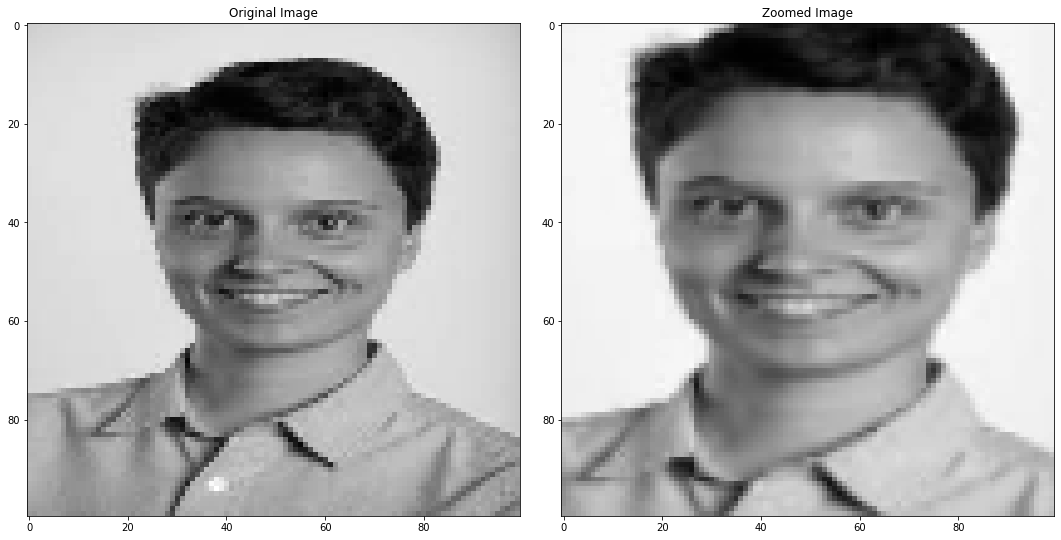

In [ ]:
image, choice = train [random.randint(0,len(train)-1)]
zoomed_image = zoom(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image, cmap='gray')
axs[1].set_title('Zoomed Image')

print (choice)

In [ ]:
def pan(image):
  pan = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

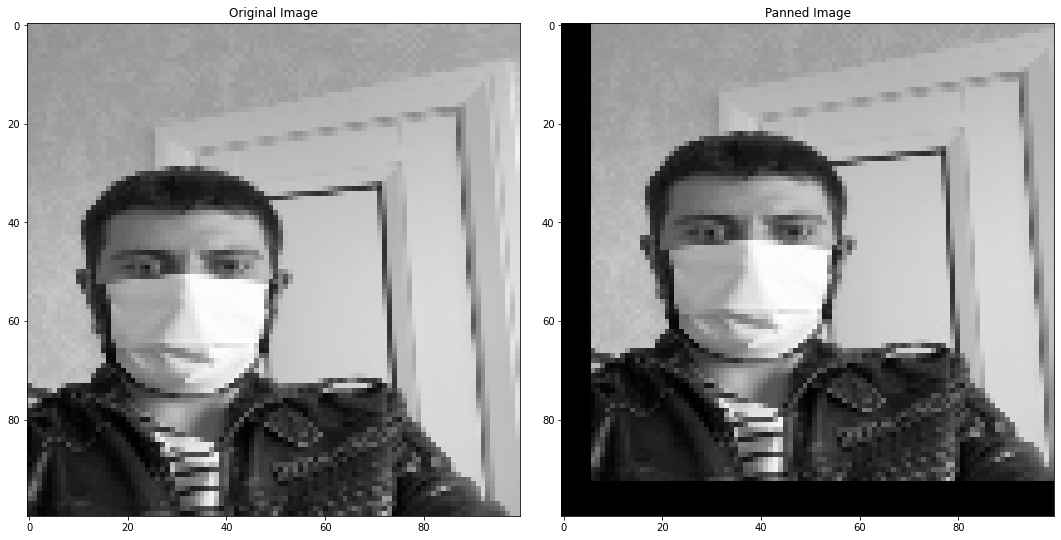

In [ ]:
image, choice = train [random.randint(0,len(train)-1)]
#original_image = npimg.imread(image)
panned_image = pan(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(panned_image, cmap='gray')
axs[1].set_title('Panned Image')

In [ ]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'bright_image')

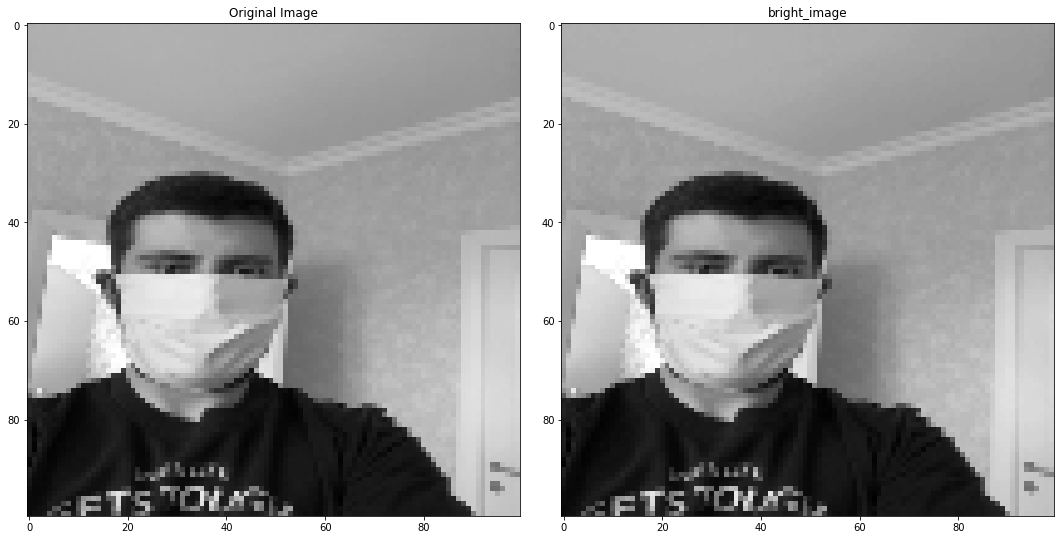

In [ ]:
image, choice = train_data [random.randint(0,len(train_data)-1)]
bright_image = img_random_brightness(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(bright_image, cmap = 'gray')
axs[1].set_title('bright_image')

In [ ]:
def img_random_flip(image):
  image = cv2.flip(image, 1)
  return image

Text(0.5, 1.0, 'flip_image')

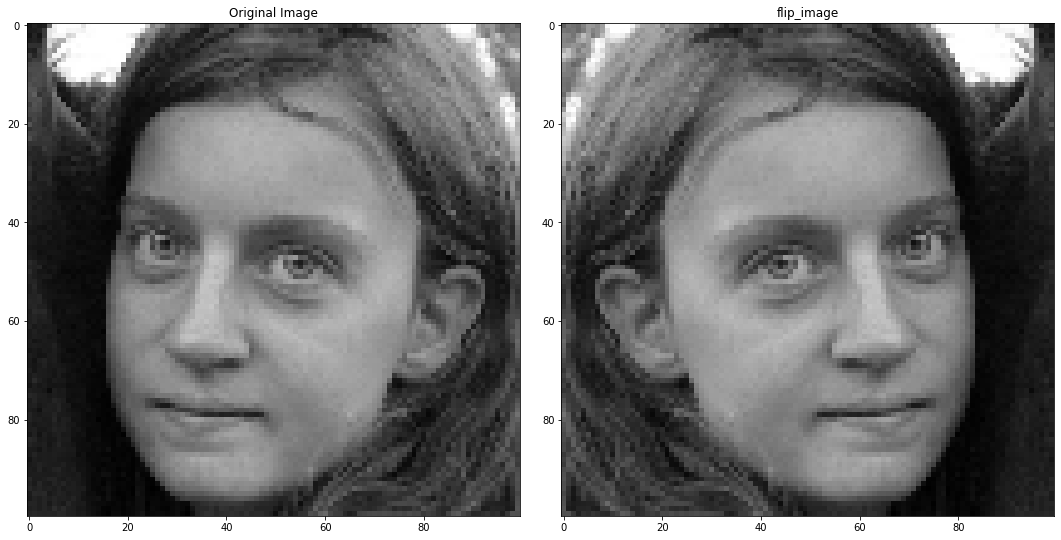

In [ ]:
image, choice = train_data [random.randint(0,len(train_data)-1)]
flip_image = img_random_flip(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(flip_image,cmap='gray')
axs[1].set_title('flip_image')

In [ ]:
def random_augment(image, choice):
    #image = npimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image = img_random_flip(image)
    
    return image, choice

In [ ]:
def batch_generator(train_data_to_generate, batch_size, istraining):
  while True:
    batch_img = []
    batch_ch = []

    for i in range(batch_size):
      random_index = random.randint(0, len(train_data_to_generate)-1)
      image, choice = train_data_to_generate[random_index]

      if istraining:
        im, ch= random_augment(image, choice)
        #ch = choice
      else:
        im = image
        ch = choice
      
      im = im.reshape(100,100,1)

      batch_img.append(im)
      batch_ch.append(ch)
    yield (np.asarray(batch_img), np.asarray(batch_ch))

In [ ]:
def keras_CNN():
  model = Sequential()

  #1st layer
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(100, 100,1),activation='relu'))

  #2nd layer
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='relu'))

  #3rd layer
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='relu'))
  
  #4th layer
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))

  #5th layer
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))

  #1st Dense Layer
  model.add(Flatten())
  model.add(Dense(200, activation='relu'))
  #model.add(Dropout(0.5))

  #2nd Dense Layer
  model.add(Dense(100, activation='relu'))
  #model.add(Dropout(0.5))

  #2nd Dense Layer
  model.add(Dense(50, activation='relu'))
  #model.add(Dropout(0.5))

  #3rd Dense Layer
  model.add(Dense(20, activation='relu'))
  #model.add(Dropout(0.5))

  #output
  model.add(Dense(2, activation='softmax'))
  
  #Compile model
  model.compile(Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
#model = tf_CNN()
model = keras_CNN()
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 48, 48, 24)        624       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 22, 22, 36)        21636     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 9, 9, 48)          43248     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 7, 7, 64)          27712     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 5, 5, 128)         73856     
_________________________________________________________________
flatten_7 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 200)              

In [ ]:

history = model.fit_generator(batch_generator(train,100,1),
                              steps_per_epoch = 20, 
                              epochs = 20,
                              validation_data = batch_generator(test, 50, 0),
                              validation_steps = 2,
                              verbose = 1, 
                              shuffle=1)
'''                            
history = model.fit(x=train_x, y=train_y, 
                    batch_size=50, 
                    epochs=20, 
                    verbose=1, 
                    validation_data=(val_x, val_y), 
                    shuffle=True)
'''


Epoch 1/20
20/20 [==============================] - 6s 281ms/step - loss: 0.4159 - accuracy: 0.8240 - val_loss: 0.3033 - val_accuracy: 0.8600
Epoch 2/20
20/20 [==============================] - 6s 278ms/step - loss: 0.3796 - accuracy: 0.8300 - val_loss: 0.3139 - val_accuracy: 0.8300
Epoch 3/20
20/20 [==============================] - 6s 282ms/step - loss: 0.3248 - accuracy: 0.8745 - val_loss: 0.3217 - val_accuracy: 0.8700
Epoch 4/20
20/20 [==============================] - 6s 278ms/step - loss: 0.2844 - accuracy: 0.8895 - val_loss: 0.3844 - val_accuracy: 0.8200
Epoch 5/20
20/20 [==============================] - 6s 284ms/step - loss: 0.2902 - accuracy: 0.8910 - val_loss: 0.3881 - val_accuracy: 0.8600
Epoch 6/20
20/20 [==============================] - 5s 273ms/step - loss: 0.2911 - accuracy: 0.8935 - val_loss: 0.2709 - val_accuracy: 0.9200
Epoch 7/20
20/20 [==============================] - 5s 275ms/step - loss: 0.2763 - accuracy: 0.8975 - val_loss: 0.5955 - val_accuracy: 0.8500
Epoch 

'                            \nhistory = model.fit(x=train_x, y=train_y, \n                    batch_size=50, \n                    epochs=20, \n                    verbose=1, \n                    validation_data=(val_x, val_y), \n                    shuffle=True)\n'

Text(0.5, 0, 'epoch')

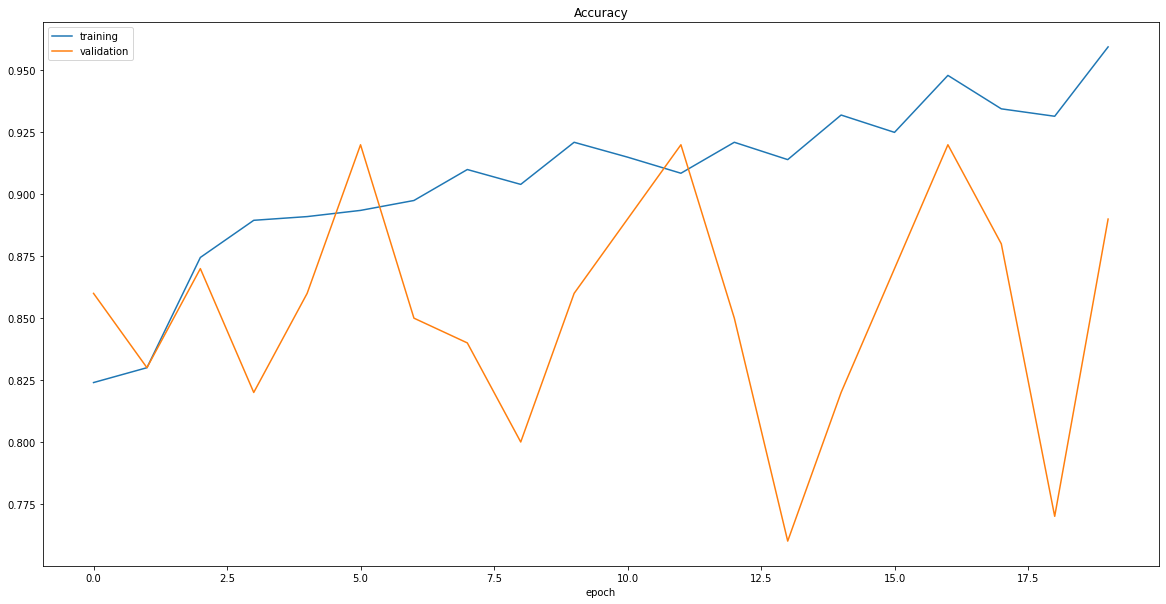

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=10)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 0s 1ms/step
test loss, test acc: [0.08366406486735126, 0.9620253443717957]


Actual:  [1, 0]
Prediction:  [[9.9994290e-01 5.7096917e-05]]


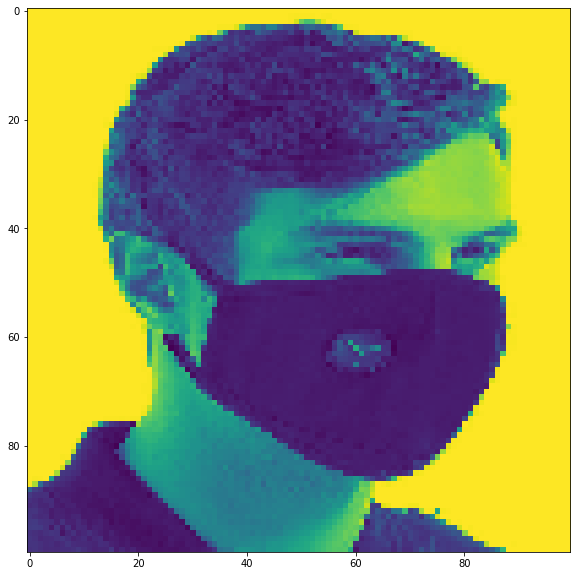

In [ ]:
img_testing, choice_testing = train_data [random.randint(0,len(test)-1)]
'''
img_testing = img_testing[50:,:]
img_testing = cv2.resize(img_testing, (WIDTH, HEIGHT))
'''
plt.imshow(img_testing)
print ("Actual: ", choice_testing)
img_testing = img_testing.reshape(-1,100 ,100,1)

print ("Prediction: ", model.predict(img_testing))

<Response [200]>


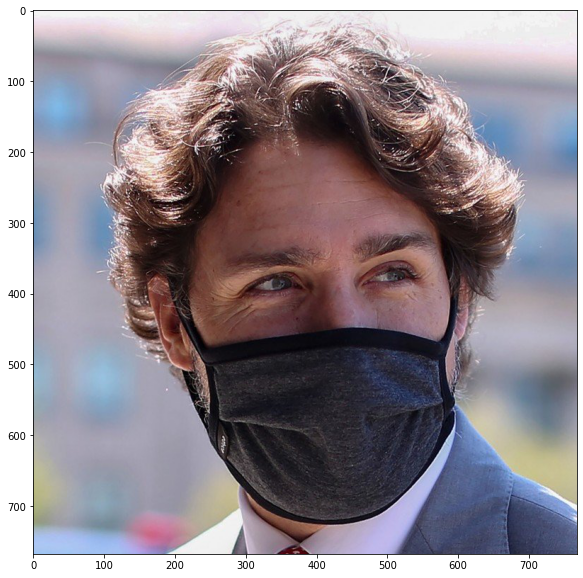

In [ ]:
import requests
from PIL import Image
url = 'https://cdn.i-scmp.com/sites/default/files/styles/768x768/public/d8/images/methode/2020/05/21/de64bb74-9ac9-11ea-96ff-7aff439fc3be_image_hires_034505.jpg?itok=4WgSNs2d&v=1590003915'
response = requests.get(url, stream = True)
print(response)
img = Image.open(response.raw)
plt.imshow(img)

(100, 100)


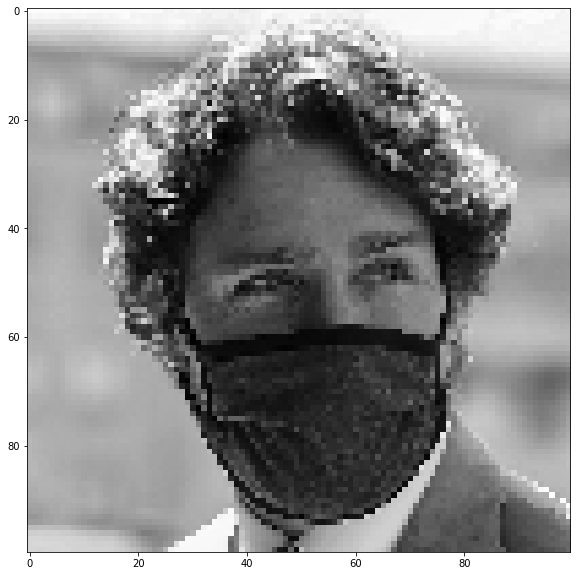

In [ ]:
img_array = np.asarray(img)
resized = cv2.resize(img_array, (100, 100))
grey_scale = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
#image = cv2.bitwise_not(grey_scale)
plt.imshow(grey_scale, cmap=('gray'))
print (grey_scale.shape)
grey_scale = np.array(grey_scale).reshape(-1, 100, 100, 1)

In [ ]:
prediction = model.predict(grey_scale)
print ('Prediction is:', prediction)

Prediction is: [[9.9933738e-01 6.6263555e-04]]


In [ ]:
model.save('detect.h5')